# Demo: A High-Order Method for the Kuramoto-Sivashinsky Equation

In [1]:
import numpy as np

from numpy.fft import fft, ifft, fftfreq, fftshift, rfft

import matplotlib.pyplot as plt
import matplotlib.animation as animation

import cmocean
import cmocean.cm as cmo

import time

import sys

# this makes sure the images don't come out looking muddy on 
# retina displays (which your computer probably uses)
%config InlineBackend.figure_format='retina'

In this demo ... 

## Suggested References

- Aly-Khan Kassam and Lloyd Nick Trefethen, "Fourth-order time-stepping for Stiff PDEs", SIAM J. Sci. Comput. , Vol. 26, No. 4, pp. 1214–1233, 2005

- Nicholas Higham, *Functions of Matrices: Theory and Computation*, SIAM, 2008


## Background Theory

In [2]:
# TODO: discuss explicitly how the contour integral formulas we use IN THE CODE appear.
# Do the change of variables computation explicitly! Also say that we can prolly just get away
# with using the mean value property for analytic functions. 

## Numerical Examples

In [3]:
T = 150. # time to stop simulation at 

In [4]:
length = 32.*np.pi

# number of grid cells per unit axis
N = 2**9

x = np.linspace(0., length, N, endpoint = False) # the endpoint = False flag is critical! 

In [5]:
def initial_state(x):
    out = np.cos(2.*np.pi*x/length)*(1. + np.sin(2.*np.pi*x/length))
    return out 

In [6]:
# TODO: plot power spectrum of initial state ... starting point of the investigation of CHAOS
# k = fftfreq(N)*N
# plt.plot(fftshift(k), fftshift(np.absolute(uf))/N)
# plt.show()

In [7]:
dt = 0.25 # time step size

nsteps = int(T/dt) # total num of time steps we take

In [8]:
k = 2*np.pi*N*fftfreq(N)/length # wavenumbers 

L = k**2 - k**4

In [9]:
def fourier_forcing(v):
    # Fourier transform of forcing term, acting on fncs on Fourier space
        
    out = -0.5j*k*fft(np.real(ifft(v))**2)
    
    return out

In [10]:
# compute all the required phi-functions via applying the trapezoid rule to approximate 
# appropriate Cauchy contour integrals. 

def get_phi1(z, num_samples = 16):
    N = np.size(z)
    
    theta = np.linspace(0., 2.*np.pi, num = num_samples, endpoint= False)
        
    # as we saw in the contour integration demo, a slick use of numpy functions
    # allows us to evaluate phi1 without using a loop!
    z0 = np.tile(z,(num_samples,1)) + np.tile(np.exp(1j*theta) ,(N,1)).T
    
    phi1 = np.real(np.mean((np.exp(z0)-1.)/z0,0)) # note how we take mean over a certain axis

    return phi1

def get_greeks(z, num_samples = 16):
    
    N = np.size(z)

    theta = np.linspace(0,2.*np.pi, num = num_samples, endpoint= False)
    
    z0 = np.tile(z,(num_samples,1)) + np.tile(np.exp(1j*theta) ,(N,1)).T
    
    alpha =np.real(np.mean( (-4.-z0+np.exp(z0)*(4.-3.*z0+z0**2))/(z0**3),0)) # again note axis
    # argument of np.mean
        
    beta =np.real(np.mean( (2.+z0+np.exp(z0)*(-2.+z0))/(z0**3), 0))
        
    gamma = np.real(np.mean((-4.-3.*z0-z0**2+np.exp(z0)*(4.-z0))/(z0**3),0))

    return alpha, beta, gamma

The very fine accuracy of the Cauchy integral method of approximating $\phi_{1}$ has already been investigated in the contour integral demo. 

Now we actually prepare the matrices ($\phi_1$ and Greeks and propagators) we'll use for our time-stepping. 

In [11]:
start= time.time()
phi1 = get_phi1(0.5*dt*L)
alpha, beta, gamma = get_greeks(dt*L)

propagator = np.exp(dt*L)
propagator2 = np.exp(0.5*dt*L)

In [12]:
ndump = 6. 

uinit = initial_state(x)

v = fft(uinit)

# make data storage array
udata = np.zeros([int(nsteps/ndump), N], dtype=float)
udata[0,:] = uinit

cnt = 0. # counter 

for n in np.arange(1,nsteps):
    
    vhalf = propagator2*v
    
    fv = fourier_forcing(v)
    
    a = vhalf + 0.5*dt*phi1*fv
    
    fa = fourier_forcing(a)
    
    b = vhalf + 0.5*dt*phi1*fa
    
    fb = fourier_forcing(b)
    
    c = propagator2*a + 0.5*dt*phi1*(2.*fb - fv)
    
    fc = fourier_forcing(c)
        
    # now assemble the guess at the new step
    v = propagator*v + dt*(alpha*fv + 2.*beta*(fa + fb) + gamma*fc)
            
    cnt+=1
    
    if cnt%ndump == 0: 
        
        udata[int(n/ndump),:] = np.real(ifft(v))
        
    else: 
        
        pass
    
end =time.time()
runtime=end-start
print('Runtime = ', runtime,'s')

Runtime =  0.11945462226867676 s


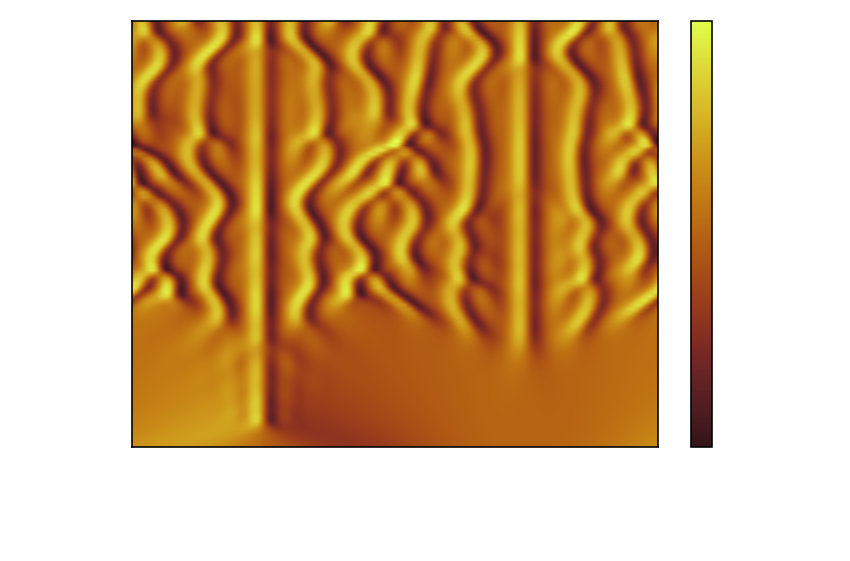

In [13]:
# MAKE FILLED CONTOUR PLOT OF SOLN
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig = plt.figure()

times = np.linspace(0., T, num=int(nsteps/ndump), endpoint=True)

CF = plt.contourf(x,times,udata, levels=300, cmap = cmo.solar) 
# good choices of cmap: solar, matter, thermal 

# axis labels
plt.xlabel(r"$x$", fontsize=26, color = 'w')
plt.ylabel(r"$t$", fontsize=26, color='w')

plt.tick_params(axis='x', which='both', top='off', color = 'w')
plt.xticks(fontsize=18, rotation=0, color = 'w')
plt.tick_params(axis='y', which='both', right='off', color = 'w')
plt.yticks(fontsize=18, rotation=0, color = 'w')

# make colorbar
cbar = plt.colorbar(CF,  format='%.1f')
cbar.ax.tick_params(labelsize=16, color='w') 
#plt.clim(0,np.amax(z))
cbar.ax.set_ylabel(r'$u(x,t)$', fontsize=26, color='w')

# the final piece of the colorbar defn is to change the colorbar ticks to an acceptable color.
# This is not so easy, and relies on the thread at
# https://stackoverflow.com/questions/9662995/matplotlib-change-title-and-colorbar-text-and-tick-colors
cbytick_obj = plt.getp(cbar.ax.axes, 'yticklabels')                
plt.setp(cbytick_obj, color='w')

plt.tight_layout()

plt.show()

In [14]:
# the picture displayed above passes Kutta's bronze standard in dt and dx! 

In [15]:
# TODO: 
#-more investigations of chaos via the nonlinear evolution of the power spectrum... 
#discuss the scale differences

#-Add physics background and motivation... pick a specific application and go with it. 

#-add more options for initial conditions to demonstrate different types of behaviour? 

#-Interesting remark: the standing waves in the Hov plot are stuck near the locations of 
# the "shocks" resulting from u_{0} having local max and min. More interesting things to
# say about this?

In [16]:
sys.exit()

SystemExit: 

/home/adam/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
# Create movie file in mp4 format. Warning: this is very slow!
plt.rc('text', usetex=True)
plt.rc('font', family='serif') 
   
fig = plt.figure()
ax = plt.axes(xlim=(0, length), ylim=(-3., 3.)) 

ax.grid('True')
ax.set_xlabel('$x$', fontsize=22)

line, = ax.plot([], [], linewidth=2, color='xkcd:dusty orange')

# Initialization function for backgrounds
def init():
    line.set_data([], [])
    return line,
    
timer = fig.canvas.new_timer(interval=100)  
timer.add_callback(udata, ax)  
timer.start() 

# Animation function.
def animate(i):

    line.set_data(x, udata[i,:])
    
    tplot = i*dt*ndump
    
    ax.set_ylabel('$u(x,t=%.2f)$' % tplot, fontsize=22)
    
    plt.tight_layout()
    
    return line,
    
anim = animation.FuncAnimation(fig,animate,int(nsteps/ndump),blit=False)
                               
dpi = 800
anim.save('ks_chaos' + '.mp4', fps=10, extra_args=['-vcodec', 'libx264'], dpi = dpi)